<a href="https://colab.research.google.com/github/elenaajayi/Computer-Vision-Fundamentals---CUS-754/blob/main/Capstone_Project/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#import libraries
import os
from pathlib import Path
import pandas as pd
from PIL import Image
import numpy as np
import cv2
from skimage.filters import threshold_otsu
from skimage import morphology

In [3]:
from google.colab import drive
drive.mount('/content/drive') # Mount to the existing '/content/drive' directory

Mounted at /content/drive


In [5]:
# point to your mounted drive folder in Colab
base_dir = Path('/content/drive/MyDrive/ProjectMaterials/dataset')

#defining the exact image & mask subfolders
images_dir = base_dir / 'HAM10000_images'
masks_dir  = (base_dir / 'HAM10000_masks' / 'HAM10000_segmentations_lesion_tschandl')

#loading metadata
metadata_df = pd.read_csv(base_dir / 'HAM10000_metadata.csv')


In [ ]:
!pip install opencv-python scikit-image tensorflow matplotlib pandas


In [7]:
meta_path = base_dir / 'HAM10000_metadata.csv'
meta_data_df = pd.read_csv(meta_path)

In [8]:
 #– images are named e.g. ISIC_0000000.jpg
#    – masks are named e.g. ISIC_0000000_segmentation.png
meta_data_df['image_path'] = meta_data_df['image_id'].apply(lambda x: str(images_dir / f"{x}.jpg"))
meta_data_df['mask_path']  = meta_data_df['image_id'].apply(lambda x: str(masks_dir  / f"{x}_segmentation.png"))


In [9]:
# If any are missing, it probably means you typo’d a folder name or
# didn’t unzip something in the right place.
missing_imgs = [p for p in meta_data_df['image_path'] if not Path(p).exists()]
missing_masks = [p for p in meta_data_df['mask_path'] if not Path(p).exists()]

print(f"Total records: {len(meta_data_df)}")
print(f"Images missing: {len(missing_imgs)}")
print(f"Masks  missing: {len(missing_masks)}")


Total records: 10015
Images missing: 0
Masks  missing: 0


In [10]:
img = np.array(Image.open(meta_data_df.loc[0, 'image_path']))
mask = np.array(Image.open(meta_data_df.loc[0, 'mask_path']))
print(f"Original shapes: {img.shape} (H×W×3), {mask.shape} (H×W)")


Original shapes: (450, 600, 3) (H×W×3), (450, 600) (H×W)


In [11]:
def segment_lesion_hsv_otsu(image: np.ndarray) -> np.ndarray:
    #convert to HSV
    hsv      = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    sat      = hsv[:, :, 1]
    #otsu threshold on saturaion
    thresh   = threshold_otsu(sat)
    raw_mask = sat > thresh
    #clean up objects and holes
    clean    = morphology.remove_small_objects(raw_mask, min_size=500)
    clean    = morphology.remove_small_holes(clean, area_threshold=500)
    return clean.astype(np.uint8)

In [12]:
# load them in a loop
# load first image+mask pair
img = np.array(Image.open(meta_data_df .loc[0, 'image_path']))
mask = np.array(Image.open(meta_data_df .loc[0, 'mask_path']))
print("Original shapes:", img.shape, mask.shape)


Original shapes: (450, 600, 3) (450, 600)


In [13]:
#try auto segmentation on our example
auto_mask  = segment_lesion_hsv_otsu(img)
print("Auto-mask shape:", auto_mask.shape)


Auto-mask shape: (450, 600)


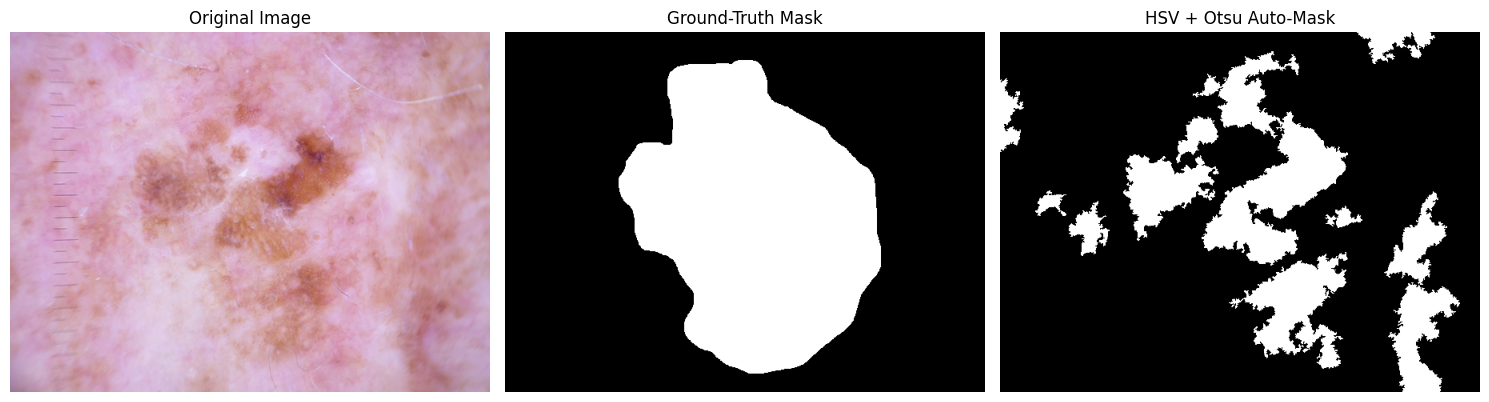

In [16]:
import matplotlib.pyplot as plt

#plot the results to see how close we got
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img);            axes[0].set_title("Original Image");       axes[0].axis('off')
axes[1].imshow(mask, cmap='gray'); axes[1].set_title("Ground-Truth Mask"); axes[1].axis('off')
axes[2].imshow(auto_mask, cmap='gray'); axes[2].set_title("HSV + Otsu Auto-Mask"); axes[2].axis('off')
plt.tight_layout()
plt.show()


In [17]:
#apply to image
masked_img = img.copy()
masked_img[auto_mask == 0] = 0